In [22]:
import numpy as np

import rasterio as rio
import xarray as xr
import rioxarray as rxr

from matplotlib import pyplot

In [29]:
QA_BIT = {'fill': 0,
'dilated cloud': 1,
'cirrus': 2,
'cloud':3,
'cloud shadow':4,
'snow':5,
'clear': 6,
'water': 7,
'cloud confidence l': 8,
'cloud confidence h': 9,
'cloud shadow confidence l': 10,
'cloud shadow confidence h': 11,
'snow/ice confidence l': 12,
'snow/ice confidence h': 13,
'cirrus confidence l': 14,
'cirrus confidence h': 15
}

def mask_landsat(qa_arr, mask_list=['fill', 'Cloud', 'Cloud Shadow', 'Cloud Confidence high', 'Cloud Confidence moderate', 'Cloud Shadow Confidence high']):
    # This function takes the Landsat QA array as input and exports the cloud mask array. 
    # The mask_list assigns the QA conditions you would like to mask.
    # The list accept QA_BIT keys: "fill" to "water"; and confidence with 'high', 'moderate', or 'low' (e.g., Cloud Confidence high)
    msk = np.zeros_like(qa_arr)#.astype(bool)
    mask_list = [x.lower() for x in mask_list]
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (qa_arr & 1 << QA_BIT[m]) > 0
        if m.endswith("high"):
            l_bit = m.replace("high", 'l')
            h_bit = m.replace("high", 'h')
            msk += ((qa_arr & (1 << QA_BIT[h_bit])) > 0) * ((qa_arr & (1 << QA_BIT[l_bit])) > 0)
        if m.endswith("moderate"):
            l_bit = m.replace("moderate", 'l')
            h_bit = m.replace("moderate", 'h')
            msk += ((qa_arr & (1 << QA_BIT[h_bit])) > 0) * ((qa_arr | (1 << QA_BIT[l_bit])) != qa_arr)
        if m.endswith("low"):
            l_bit = m.replace("low", 'l')
            h_bit = m.replace("low", 'h')
            msk += ((qa_arr | (1 << QA_BIT[h_bit])) != qa_arr) * ((qa_arr & (1 << QA_BIT[l_bit])) > 0)
    return msk > 0

In [9]:
print("Cloud Shadow Confidence high".endswith("low"))
print("Cloud Shadow Confidence high".endswith("high"))
print("Cloud Shadow Confidence high".lower())

False
True
cloud shadow confidence high


<xarray.DataArray (band: 1, y: 7941, x: 7841)> Size: 125MB
[62265381 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 63kB 2.181e+05 2.181e+05 ... 4.533e+05 4.533e+05
  * y            (y) float64 64kB 4.426e+06 4.426e+06 ... 4.188e+06 4.188e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
QA value and binary code:	 1 	 0000000000000001 Mask:	 [ True]
QA value and binary code:	 21762 	 0101010100000010 Mask:	 [False]
QA value and binary code:	 21824 	 0101010101000000 Mask:	 [False]
QA value and binary code:	 21890 	 0101010110000010 Mask:	 [False]
QA value and binary code:	 21952 	 0101010111000000 Mask:	 [False]
QA value and binary code:	 22018 	 0101011000000010 Mask:	 [ True]
QA value and binary code:	 22080 	 0101011001000000 Mask:	 [ True]
QA value and binary code:	 22146 	 0101011010000010 Mask:	 [ True]
QA value and binary code:	 22208 	 0101011011000000 Mas

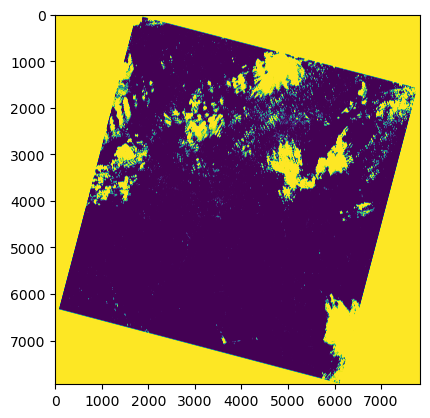

In [30]:
ras_path = r"C:\Users\qzhou2\C_workdir\QA2CloudMask\Landsat\LC09_L1TP_015033_20241105_20241105_02_T1_QA_PIXEL.TIF"

with rxr.open_rasterio(ras_path) as ds:
    print(ds)
    # ds.plot()
    qa_unq = np.unique(ds)
    for val in qa_unq:
        print('QA value and binary code:\t', val, '\t', "{0:016b}".format(val), 'Mask:\t', mask_landsat(np.asarray([val])))
    
    arr_mask = mask_landsat(ds)
    print(np.unique(arr_mask))
    pyplot.imshow(arr_mask.squeeze())
    pyplot.show()